# Gender Classification Project

In this notebook we will use [Gender Classification Dataset](https://www.kaggle.com/cashutosh/gender-classification-dataset) from Kaggle. This is a dataset with cropped images of male and female. It is split into training and validation directory. Training contains ~23,000 images of each class and validation directory contains ~5,500 iamges of each class. Our *goal* is to correctly predict gender: `male` or `female`. 

To achieve better result, we will use [ResNet](https://arxiv.org/abs/1512.03385)(Residual Network) model variants. ResNet was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), and won it in 2015.


## Data Processing

We start by importing all the necessary modules
 - `lr-scheduler` - for using the one cycle learning rate schedule, from [this paper](https://arxiv.org/abs/1803.09820)
 - `namedtuple` - for handling ResNet configurations
 - `os` and `shutil` for handling custom datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy 
from collections import namedtuple
import os
import random
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

We set the random seeds for reproducability

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load and Augment Data

In [3]:
data_dir = 'D:/datasets/gender_kaggle'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Validation')
classes = os.listdir(train_dir)

In [4]:
classes

['female', 'male']

### Normalizing the data

In [5]:
# train_data = datasets.ImageFolder(root=train_dir, transform = transforms.ToTensor())

# means = torch.zeros(3)
# stds = torch.zeros(3)

# for img, label in train_data:
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))
    
# means /= len(train_data)
# stds /= len(train_data)

# print(f'Calculated means: {means}')
# print(f'Calculated stds: {stds}')

### Augmentation

As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/vision/stable/models.html) page.

We use the following data augmentation methods: randomly  rotating, flipping horizontally and cropping.

In [6]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

# load the data with transforms
train_data = datasets.ImageFolder(root=train_dir, transform = train_transforms)

test_data = datasets.ImageFolder(root=test_dir, transform = test_transforms)

# create the validation split
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

overwrite the validation transforms, making sure to do a deepcopy to stop this also chaing the training data transforms

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Now let's see the number of examples for each of the data splits

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 42308
Number of validation examples: 4701
Number of testing examples: 11649


Now, we prepare dataloader (combine dataset and sampler) with largest batch size that fits on our GPU

In [9]:
BATCH_SIZE = 32

train_loader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)

valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

In [10]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [11]:
def plot_images(images, labels, classes, normalize = True):
    
    n_images = len(images)
    
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    
    fig = plt.figure(figsize=(10,10))
    
    for i in range(rows*cols):
        
        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        
        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [12]:
test_data.classes

['female', 'male']

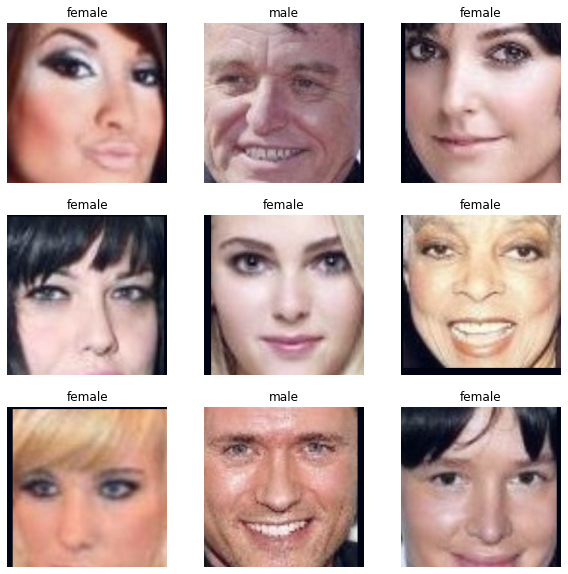

In [13]:
N_IMAGES = 9

images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

# Define the Network [Architecture](https://pytorch.org/docs/stable/nn.html)


We will use ResNet-50 pre-trained model

In [14]:
model = models.resnet50(pretrained=True)
# print(model)

Our dataset only has 2 classes, so we first create a new linear layer with the required dimensions.

In [15]:
IN_FEATURES = model.fc.in_features
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

model.fc = fc

In [16]:
# print(model)

We can also see the number of parameters in our model

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,512,130 trainable parameters


# Training

## Specify Loss Function and Optimizer¶



### LRFinder

Next we'll move on to training our model. We'll use the learning rate finder to set a suitable learning rate for our model.

We start by initializing an optimizer with a very low learning rate, defining a loss function (criterion) and device, and then placing the model and the loss function on to the device.

In [18]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We define the learning rate finder class.

In [19]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

We then define our learning rate finder and run the range test.

In [20]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we define a function to plot the results of the range test.

In [21]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
        
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
        
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

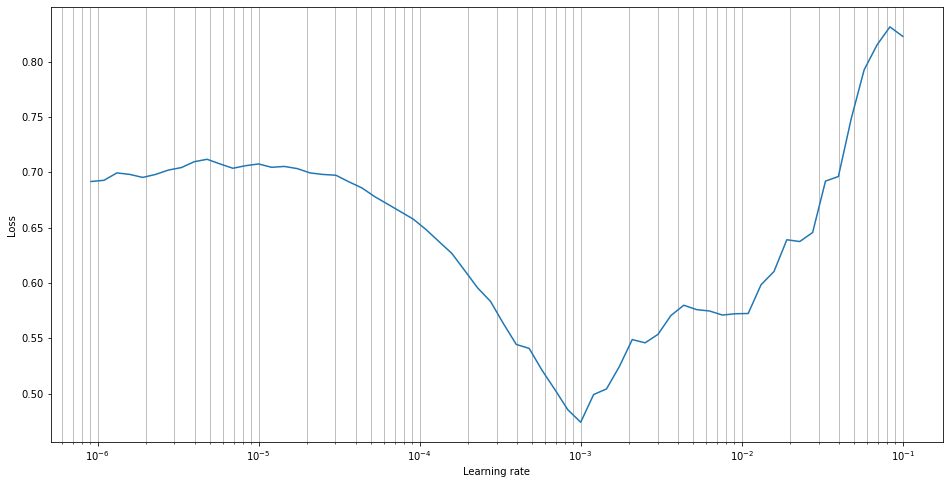

In [22]:
plot_lr_finder(lrs, losses, skip_start=10, skip_end=20)

We can now create an optimizer with our found learning rate and using discriminative fine-tuning.

The concept behind descriminative fine-tuning is that we use different learning rates for different layers in our models. The hypothesis is that early layers in a neural network learn to extract more general features, whilst later layers learn to extract more task specific features. If this is true, then the general features extracted by the early layers should be useful for any task, and we should change the pre-trained weights of them by a very small amount - if at all.

**Note:** discriminative fine-tuning should only be used when performing transfer learning from a pre-trained model. It is typically not necessary to use it when training a model from randomly initialized weights.

PyTorch allows us to set different learning rate values per parameter in our model. This is done by passing a list of dictionaries to the optimizer. Each dictionary should state the parameters ('`params`') and also any other arguments that will override those given directly to the optimizer.

Here, instead of using a different learning rate for every single layer, we have split the parameters into two "groups": `features`, which contains all of the convolutional layers; and `classifier`, which contains all of the linear layers. `classifier` will be using the FOUND_LR given directly to the optimizer and `features` will be using FOUND_LR / 10, as specified in the first dictionary. Thus, our convolutional layers have a learning rate 10x less than the linear layers.

In [23]:
FOUND_LR = 3e-4

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [24]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

We create a function to calculate accuracy...

In [25]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Next up is the training function. 

The scheduler is updated by calling `scheduler.step()`. This should always be called **after** `optimizer.step()` or else the first learning rate of the scheduler will be skipped.

Not all schedulers need to be called after each training batch, some are only called after each epoch. In that case, the scheduler does not need to be passed to the train function and can be called in the main training loop.

In [26]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...create a function that performs an evaluation loop...


As the one cycle scheduler should only be called after each parameter update, it is not called here as we do not update parameters whilst evaluating.

In [27]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Next, a small helper function which tells us how long an epoch has taken.

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 6m 3s
	Train Loss: 0.197 | Train Acc: 92.40%
	 Val. Loss: 0.118 |  Val. Acc: 96.02%
Epoch: 02 | Epoch Time: 8m 20s
	Train Loss: 0.113 | Train Acc: 96.12%
	 Val. Loss: 0.088 |  Val. Acc: 97.05%
Epoch: 03 | Epoch Time: 5m 59s
	Train Loss: 0.096 | Train Acc: 96.60%
	 Val. Loss: 0.087 |  Val. Acc: 96.90%
Epoch: 04 | Epoch Time: 5m 42s
	Train Loss: 0.086 | Train Acc: 97.00%
	 Val. Loss: 0.081 |  Val. Acc: 97.07%
Epoch: 05 | Epoch Time: 5m 42s
	Train Loss: 0.074 | Train Acc: 97.31%
	 Val. Loss: 0.086 |  Val. Acc: 97.13%
Epoch: 06 | Epoch Time: 5m 41s
	Train Loss: 0.063 | Train Acc: 97.73%
	 Val. Loss: 0.086 |  Val. Acc: 97.21%
Epoch: 07 | Epoch Time: 5m 41s
	Train Loss: 0.050 | Train Acc: 98.19%
	 Val. Loss: 0.086 |  Val. Acc: 97.30%
Epoch: 08 | Epoch Time: 5m 40s
	Train Loss: 0.032 | Train Acc: 98.85%
	 Val. Loss: 0.096 |  Val. Acc: 97.26%
Epoch: 09 | Epoch Time: 5m 43s
	Train Loss: 0.021 | Train Acc: 99.25%
	 Val. Loss: 0.107 |  Val. Acc: 97.40%
Epoch: 10 | Epoch Ti

In [31]:
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

In [32]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.068 | Test Acc: 97.53%


In [45]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
        
    model.train()

In [46]:
check_accuracy(test_loader, model)

Got 11360 / 11649 with accuracy 97.52


## Examining the Model

Now we will examine the model deeeply

Firstly, let's get predictions for each of the examples in the test set

In [35]:
def get_predictions(model, iterator):
    
    model.eval()
    
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        
        for i, (x, y) in enumerate(iterator):
            
            x = x.to(device)
            
            y_pred = model(x)
            
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    
    return images, labels, probs

In [36]:
images, labels, probs = get_predictions(model, test_loader)

...then get the predicted labels for each image...



In [37]:
pred_labels = torch.argmax(probs, 1)

... and then use these predictions to create a confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

classes = test_data.classes

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

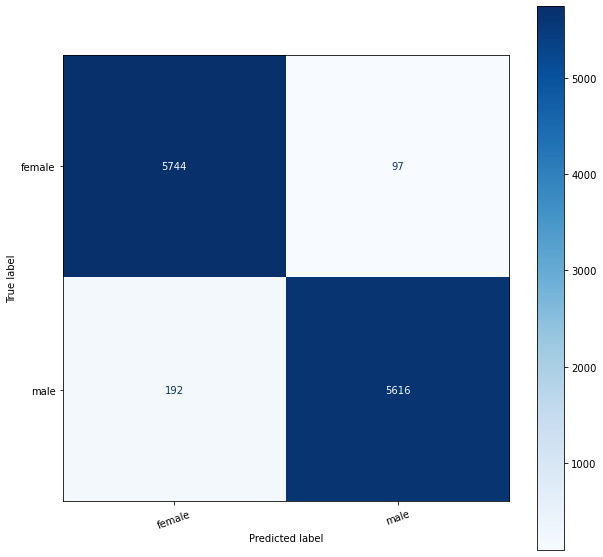

In [39]:
plot_confusion_matrix(labels, pred_labels, classes)

Now, let's see which predictions were incorrect and then sort found incorrect predictions by how confident our model is

In [40]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))
        
incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

Let's see our result in the plot

In [43]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

As it is seen, in most cases, our model predicts male incorrectly

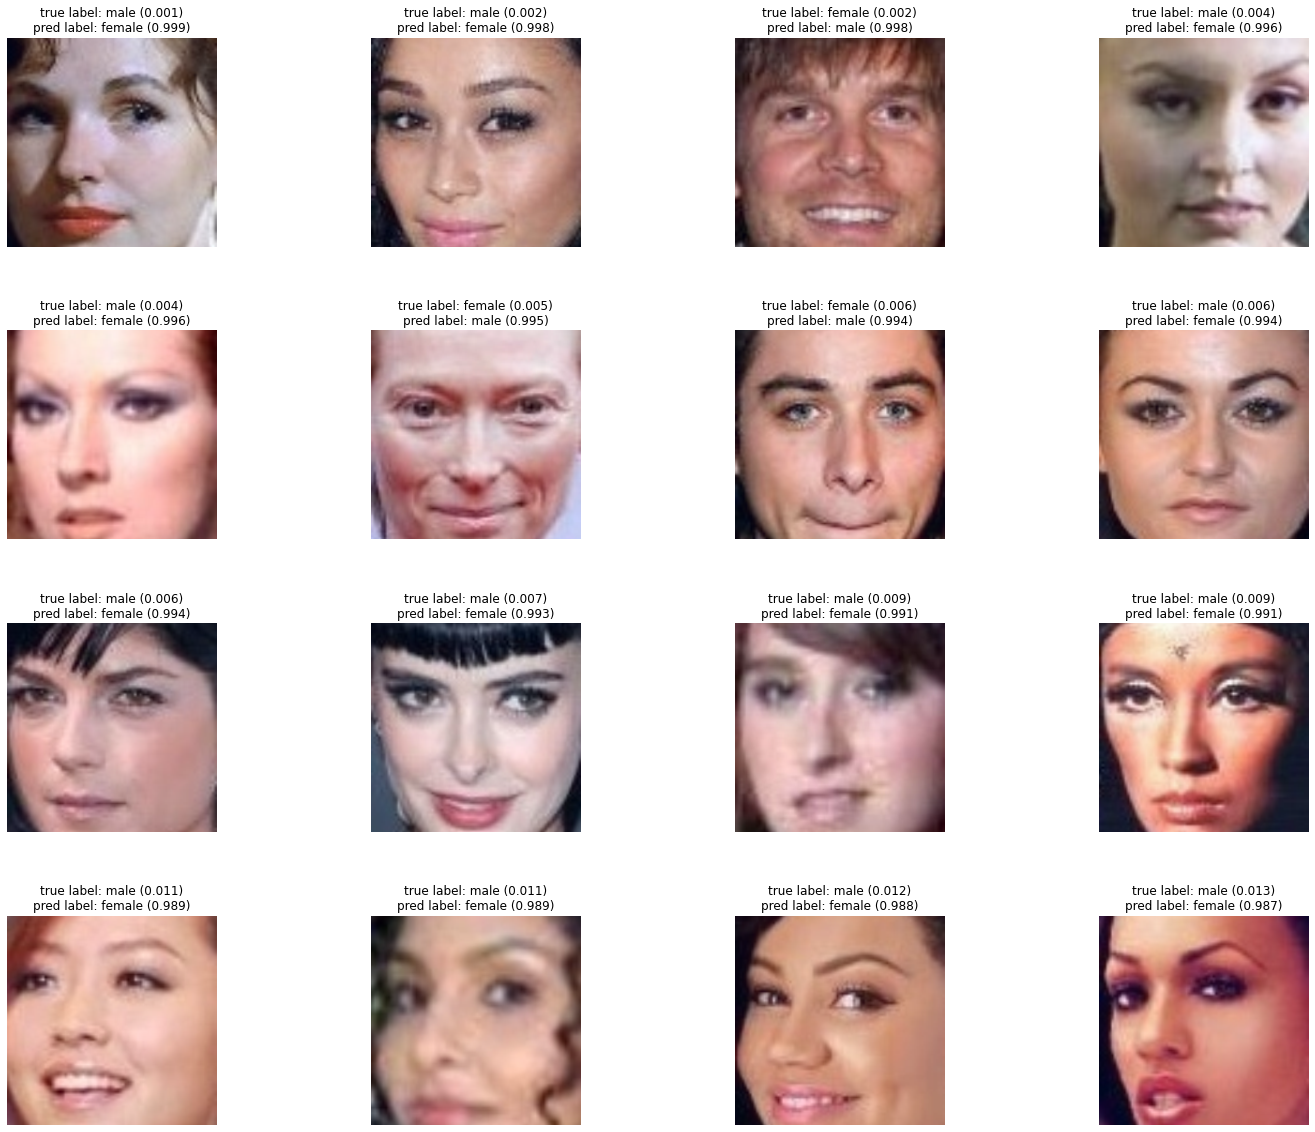

In [44]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

## Testing on Real World Images

In [ ]:
haar = '../../FaceApp/model/haarcascade_frontalface_alt.xml'

img = Image.open('../../aa/30.jpg')

img = convert_from_image_to_cv2(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = haar.dete

In [76]:
import sys
from PIL import Image
import cv2

def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    # return cv2.cvtColor(numpy.array(img), cv2.COLOR_RGB2BGR)
    return np.asarray(img)

def face_rectangle(img):
    
    haar = cv2.CascadeClassifier('../../FaceApp/model/haarcascade_frontalface_alt.xml')
    
    img = convert_from_image_to_cv2(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = haar.detectMultiScale(gray)
    
    for(x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),5)

    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [77]:
def crop_image(image):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     plt.imshow(gray, cmap='gray')

    haar = cv2.CascadeClassifier('../../FaceApp/model/haarcascade_frontalface_alt.xml')

    faces = haar.detectMultiScale(gray)

    print('Number of faces detected:', len(faces))

    for(x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     plt.imshow(cv_rgb)
#     plt.show()

    img = cv_rgb[y:y+h,x:x+w]
    return Image.fromarray(img)

In [80]:
def test_on_image(path):
    with torch.no_grad():
        image = Image.open(path)
        face_rectangle(image)
#         plt.imshow(face)
        try: 
            image = crop_image(path)
            image = test_transforms(image)
            image.unsqueeze_(0)
            image = image.to(device)
            model.load_state_dict(torch.load('tut4-model.pt'))
            model.eval()
            output = model(image)
            output = torch.max(output, 1)[1].to(device)
            res = 'Male' if output.item() == 1 else 'Female'
            print('Image predicted as', res)
   
        except:
            print('Sorry, face is not detected')

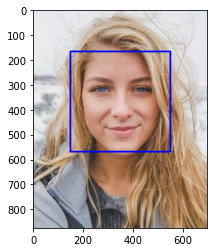

Number of faces detected: 1
Image predicted as Female


In [82]:
test_on_image('../../aa/27.jpg')

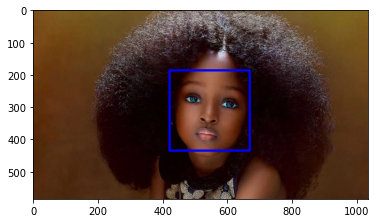

Number of faces detected: 1
Image predicted as Female


In [83]:
test_on_image('../../aa/30.jpg')

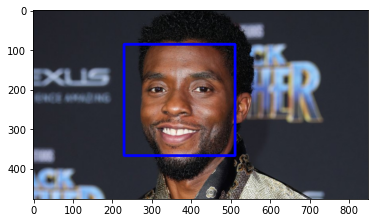

Number of faces detected: 1
Image predicted as Male


In [84]:
test_on_image('../../aa/23.jpg')